<a href="https://colab.research.google.com/github/bragarods/rainfall_forecast/blob/master/notebooks/colab_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!pip3 install --upgrade pystan
!pip3 install --upgrade fbprophet
clear_output()

In [2]:
import requests
import sys
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

%matplotlib inline

plt.rcParams['figure.figsize'] = (13, 7)

In [5]:
if sys.platform == 'linux':
  from google.colab import drive
  drive.mount('/content/drive')
  mpath = '/content/drive/My Drive/Colab Notebooks/ibba/rainfall_forecast/models'

Mounted at /content/drive


## Import monthly data

In [18]:
# google drive shareable file link

orig_url = 'https://drive.google.com/file/d/1WQ9NARYCNZxWlQUAf4Zn5TxJcnOGjEn3/view?usp=sharing'

# get file id

file_id = orig_url.split('/')[-2]

# create download url

dwn_url='https://drive.google.com/uc?export=download&id=' + file_id

# get raw text inside url

url = requests.get(dwn_url).text

# create a buffer

csv_raw = StringIO(url)

# read from buffer

df = pd.read_csv(csv_raw, index_col=0)

df.reset_index(drop=True, inplace=True)

# create sinop and csinop series

df['date'] = pd.to_datetime(df['date'], format=('%Y-%m-%d')) 

#df.set_index('date', inplace=True)

## Flag first full year of data

In [19]:
df['chuva_max_12m'] = df.groupby('cd_estacao')['chuva'].rolling(12).max().reset_index(0,drop=True)

df['flag_chuva_max_12m'] = np.where((~df['chuva_max_12m'].isna()) & (df['chuva_max_12m'] >= 1),
                               1,
                               0)

fl_year = df[df['flag_chuva_max_12m']==1].groupby('cd_estacao').agg(min_year=('date','min'),
                                                                     max_year=('date','max'),
                                                                     cap=('chuva','max'))

fl_year['min_year'] = fl_year['min_year'].dt.year+1
fl_year['max_year'] = fl_year['max_year'].dt.year
fl_year['cap'] = fl_year['cap']*1.25

df = pd.merge(df,fl_year,how='left',left_on=df.cd_estacao,right_on=fl_year.index)

df.drop(columns='key_0', inplace=True)

df2009 = df[(df['min_year'] <= 2009) & (df['max_year'] >= 2020) & (df.date >= '2009-01-01')]

## Prophet

In [20]:
# preparing data for Prophet

strain = df2009.rename(columns={'date':'ds','chuva':'y'}).sort_values(['cd_estacao','ds']).reset_index(drop=True)

strain = strain[strain['ds'] <= '2020-11-01']
strain1 = strain[strain['ds'] <= '2019-12-01']

strain['floor'] = 0
strain1['floor'] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Diagnosis

In [51]:
# Python
%%time
import itertools
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

cutoffs = pd.date_range(start='1/1/2018', end='11/1/2019', freq='MS')

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'growth': ['flat', 'linear']
}

# Choose stations

estacoes = ['A917', 'A211', 'A402', 'A803', 'A727']

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

tuning_results = pd.DataFrame([])

# Use cross validation to evaluate all parameters
for cd_estacao in estacoes:
  for params in all_params:
      print('\n', cd_estacao, '\n')
      print(params, '\n')
      m = Prophet(**params).fit(strain[strain.cd_estacao == cd_estacao])  # Fit model with given params
      df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
      df_p = performance_metrics(df_cv)
      df_p['params'] = str(params)
      df_p['cd_estacao'] = cd_estacao
      tuning_results = tuning_results.append(df_p)
      print('\n')
      clear_output()

# Find the best parameters


CPU times: user 1min 8s, sys: 32.9 s, total: 1min 41s
Wall time: 50min 18s


In [23]:
import seaborn as sns

In [52]:
tuning_results1 = tuning_results.copy()
#tuning_results1.horizon = tuning_results1.horizon.astype(str)
tuning_results1['params1'] = tuning_results['params'].map(eval).apply(pd.Series).iloc[:,0:3].astype(str).agg('-'.join, axis=1)
tuning_results1[tuning_results['params'].map(eval).apply(pd.Series).iloc[:,0:3].columns] = tuning_results['params'].map(eval).apply(pd.Series).iloc[:,0:3]

In [58]:
# save optimizations results

tuning_results1.to_excel(mpath + '/tuning_results.xlsx', index=False)

In [59]:
# save agg optimization results
tuning_results1.groupby(['cd_estacao',
                         'growth',
                         'changepoint_prior_scale',
                         'seasonality_prior_scale']).agg({'mae':['mean', 'min', 'max', 'std'],
                                                          'rmse':['mean', 'min', 'max', 'std']}).reset_index().to_excel(mpath + '/tuning_results_g.xlsx', index=False)#[['mae','rmse']].std().sort_values('mae').head(5)

A917 

                       mae       rmse
params1                              
0.5-0.1-logistic  4.368491  10.741798
0.5-0.1-linear    4.822725   9.612573
0.1-0.1-linear    4.875646   9.593612
0.01-0.1-flat     5.034381   8.655055
0.5-0.1-flat      5.034381   8.655055 

A211 

                       mae       rmse
params1                              
0.5-0.1-logistic  4.368491  10.741798
0.5-0.1-linear    4.822725   9.612573
0.1-0.1-linear    4.875646   9.593612
0.01-0.1-flat     5.034381   8.655055
0.5-0.1-flat      5.034381   8.655055 

A402 

                       mae       rmse
params1                              
0.5-0.1-logistic  4.368491  10.741798
0.5-0.1-linear    4.822725   9.612573
0.1-0.1-linear    4.875646   9.593612
0.01-0.1-flat     5.034381   8.655055
0.5-0.1-flat      5.034381   8.655055 

A803 

                       mae       rmse
params1                              
0.5-0.1-logistic  4.368491  10.741798
0.5-0.1-linear    4.822725   9.612573
0.1-0.1-linear  

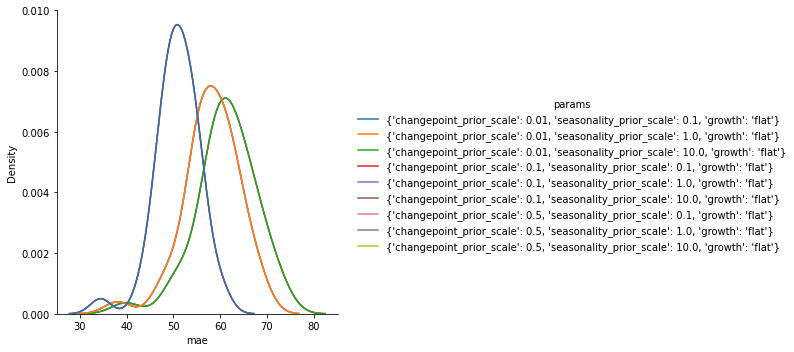

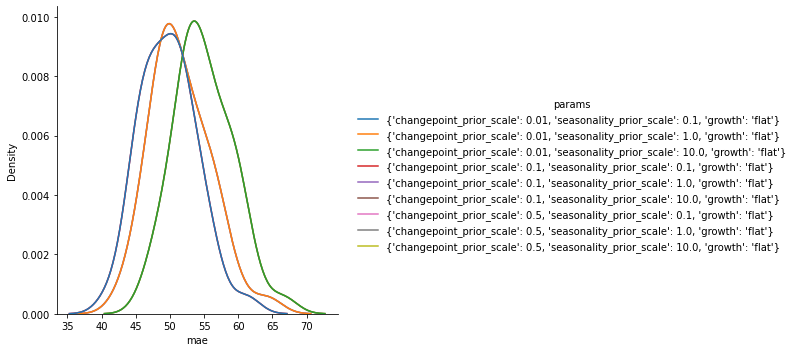

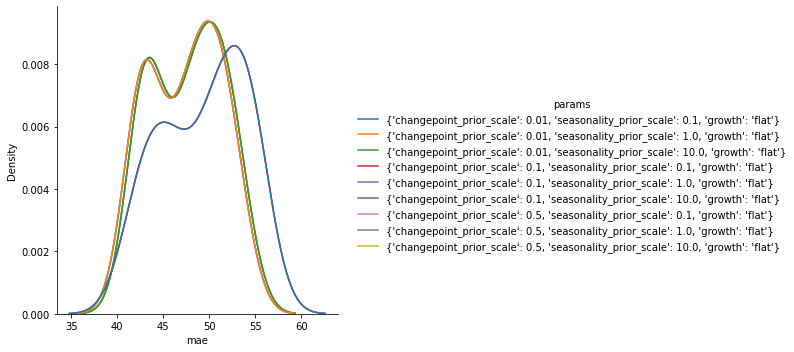

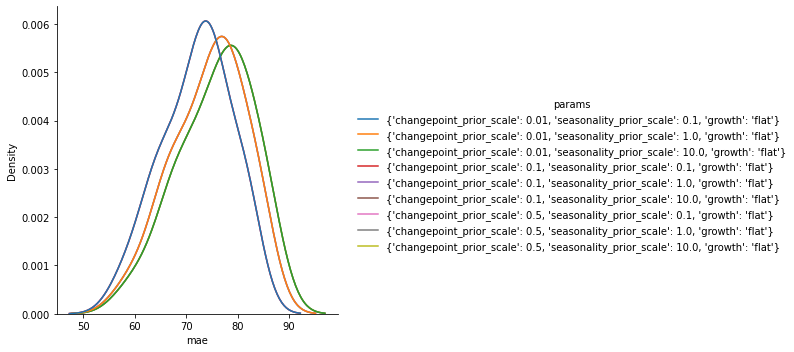

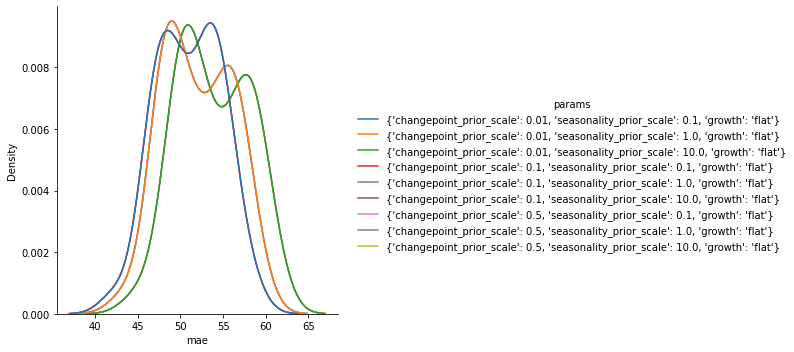

In [60]:
#tuning_results[tuning_results.cd_estacao == cd_estacao]

bparams = []
cd_estacoes = []

for cd_estacao in tuning_results.cd_estacao.unique():
  print(cd_estacao,'\n')
  #bparam = tuning_results1.groupby('params1')[['mae','rmse']].std().sort_values('mae').head(5)
  #bparams.append(bparam.index.values)
  cd_estacoes.append(cd_estacao)
  print(bparam,'\n')
  ax = sns.displot(tuning_results1[(tuning_results1.cd_estacao == cd_estacao) & (tuning_results1.params1.str.split('-').str[2] == 'flat')], x="mae", hue='params', kind='kde')



In [ ]:
tuning_results.head(1).params.values

array(["{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'weekly_seasonality': False, 'daily_seasonality': False}"],
      dtype=object)

## Save best model

The best model is the one with small standard deviation between mean average error measures.

In [ ]:
m = Prophet(changepoint_prior_scale = 0.5,
            seasonality_prior_scale = 0.1,
            weekly_seasonality = False,
            daily_seasonality = False).fit(strain[strain.cd_estacao == 'A001'])  # Fit model with given params

In [ ]:
# Python
import json
from fbprophet.serialize import model_to_json, model_from_json

with open(mpath + '/fbp_A001.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model




In [ ]:
with open(mpath + '/fbp_A001.json', 'r') as fin:
    m1 = model_from_json(json.load(fin))  # Load model

Text(0.5, 1.03, 'A001')

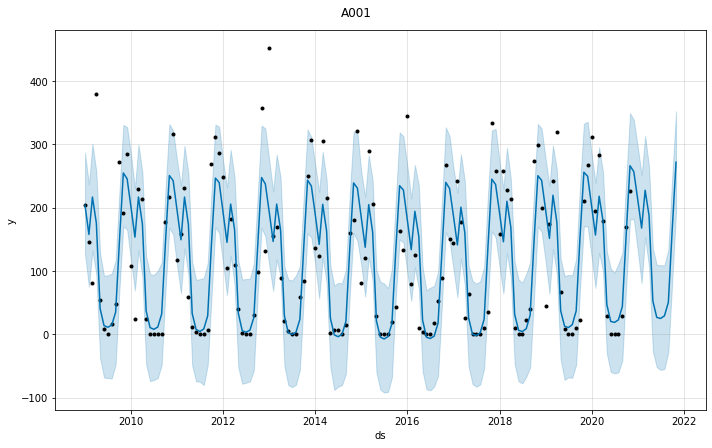

In [ ]:
future = m1.make_future_dataframe(periods=12, freq='MS')
forecast = m1.predict(future)
fig = m1.plot(forecast)
fig.suptitle('A001',y=1.03)

## Plot models

In [ ]:
from sklearn.metrics import mean_absolute_error

dict_model = {}
dff = pd.DataFrame([])

for cd_estacao in strain.cd_estacao.unique()[0:3]:
  m = Prophet()
  m.fit(strain[strain.cd_estacao == cd_estacao])
  dict_model[cd_estacao] = m
  future = m.make_future_dataframe(periods=12, freq='MS')
  forecast = m.predict(future)
  forecast['cd_estacao'] = cd_estacao
  forecast['mae'] = mean_absolute_error(df2009[(df2009.cd_estacao==cd_estacao) & (df2009.date >= '2009-01-01')].chuva, pd.Series(forecast.yhat[:-1]).clip(0))

  dff = dff.append(forecast)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


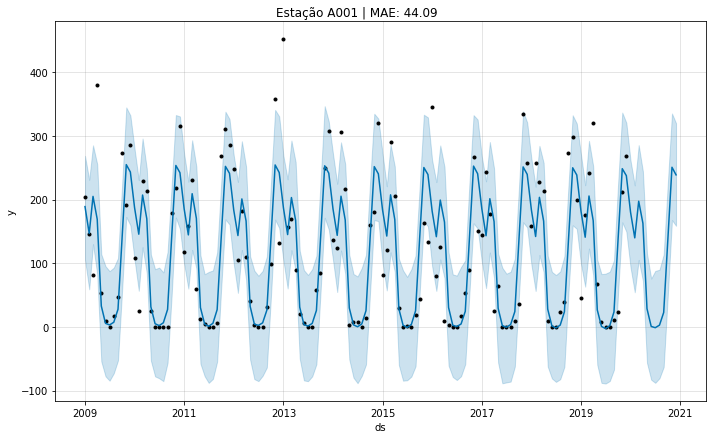

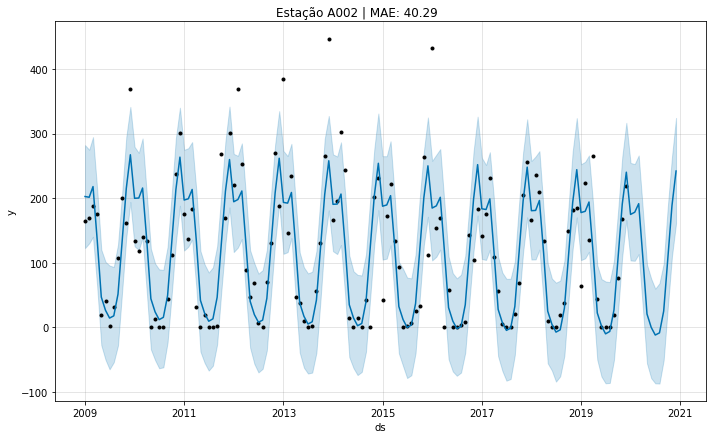

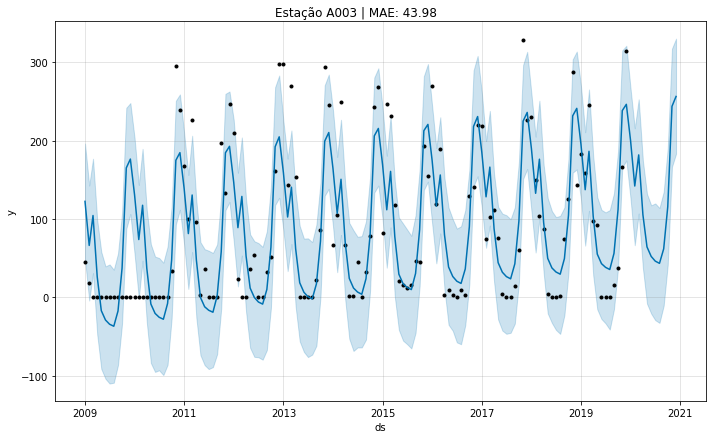

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly

#plot_plotly(dict_model['A003'], dff[dff['cd_estacao']=='A003'])
for cd_estacao in dff.cd_estacao.unique():
  fig = dict_model[cd_estacao].plot(dff[dff['cd_estacao']==cd_estacao])
  fig.suptitle('Estação {} | MAE: {}'.format(cd_estacao, dff[dff['cd_estacao']==cd_estacao].mae.head(1).values[0].round(2)), y=1.01)

In [ ]:
# Python
plot_components_plotly(m, forecast)

INFO:fbprophet:Skipping MAPE because y close to 0


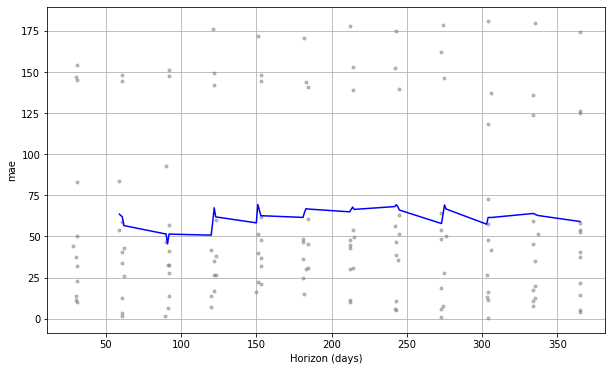

In [ ]:

from fbprophet.plot import plot_cross_validation_metric

df_cv = cross_validation(dict_model['A001'], cutoffs=cutoffs, horizon='365 days', parallel="processes")

df_p = performance_metrics(df_cv)

fig = plot_cross_validation_metric(df_cv, metric='mae')